# Stock Price Prediction Using LSTM and GRU Models

This project aims to predict stock prices using LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) models, two advanced deep learning techniques specifically designed for time series forecasting. The project leverages historical stock price data, including features like Open, High, Low, Close, Adjusted Close, and Volume, to build predictive models that forecast future stock prices.

## Load Data

In [1]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Inspecting Data

In [2]:
# Load data from ZIP
with zipfile.ZipFile('S&P 500 Stock Data.zip', 'r') as z:
    file_list = z.namelist()  # List all files (e.g., ['A.csv', 'AAL.csv', ...])
    
    # Load first 3 files as samples for inspection
    sample_data = {f: pd.read_csv(z.open(f)) for f in file_list[:3]}

# Inspect a sample file (e.g., A.csv)
print("Sample Data Structure:")
print(sample_data['A.csv'].head())
print("\nMetadata:")
print(sample_data['A.csv'].info())
print("\nMissing Values:")
print(sample_data['A.csv'].isnull().sum())
print("\nMissing Values:")
print(sample_data['A.csv'].describe())

Sample Data Structure:
  Ticker        Date       Open       High        Low      Close  Adj Close  \
0      A  1999-11-18  32.546494  35.765381  28.612303  31.473534  26.794758   
1      A  1999-11-19  30.713518  30.758226  28.478184  28.880545  24.587236   
2      A  1999-11-22  29.551144  31.473534  28.657009  31.473534  26.794758   
3      A  1999-11-23  30.400572  31.205294  28.612303  28.612303  24.358873   
4      A  1999-11-24  28.701717  29.998213  28.612303  29.372318  25.005903   

     Volume  
0  62546380  
1  15234146  
2   6577870  
3   5975611  
4   4843231  

Metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5964 entries, 0 to 5963
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     5964 non-null   object 
 1   Date       5964 non-null   object 
 2   Open       5964 non-null   float64
 3   High       5964 non-null   float64
 4   Low        5964 non-null   float64
 5   Close      5964 

## Visualizing Stock Data

The adjusted close prices for the first stock (AAPL in this case) are plotted over time to visualize the historical trend.

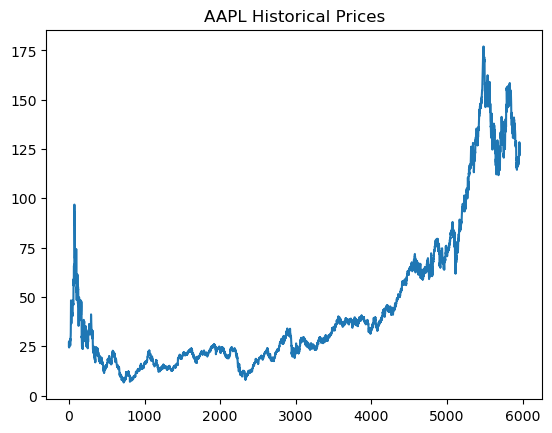

In [3]:
# Visualize a sample stock
sample_data['A.csv']['Adj Close'].plot(title='AAPL Historical Prices')
plt.show()

## Data Cleaning

This includes:

- Date Validation: Ensures the Date column is in datetime format, removing any invalid dates.
- Duplicate Handling: Removes rows with duplicate dates for the same ticker, keeping the most recent entry.
- Price Validation: Ensures price columns (Open, High, Low, Close, Adjusted Close) are numeric and checks for price consistency (e.g., High should not be lower than Low).
- Negative and Zero Prices: Removes rows where any of the price columns contain zero or negative values.
- Volume Validation: Ensures that the Volume column is numeric and non-negative.
- Date Sorting: Ensures the data is sorted chronologically.
- Daily Return Calculation: Adds a Daily_Return column that calculates the daily percentage change in adjusted close prices.

In [4]:
def clean_stock_data(df):
    """Enhanced cleaning for S&P 500 stock data"""
    
    # Convert and validate dates
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df[df['Date'].notna()]  # Remove rows with invalid dates
    
    # Handle duplicates (same ticker + date)
    df = df.drop_duplicates(subset=['Ticker', 'Date'], keep='last')
    
    # Validate price columns (OHLC)
    price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    df[price_cols] = df[price_cols].apply(pd.to_numeric, errors='coerce')
    
    # Price consistency checks
    df = df[
        (df['High'] >= df[['Open', 'Low', 'Close']].max(axis=1)) &
        (df['Low'] <= df[['Open', 'High', 'Close']].min(axis=1))
    ]
    
    # Handle zero/negative prices
    df = df[(df[price_cols] > 0).all(axis=1)]
    
    # Volume validation
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
    df = df[df['Volume'] >= 0]
    
    # Sort by date
    df = df.sort_values('Date')
    
    # Calculate returns for later analysis
    df['Daily_Return'] = df.groupby('Ticker')['Adj Close'].pct_change()
    
    return df

# Loading and Cleaning All Data

cleaned_data = {}
with zipfile.ZipFile('S&P 500 Stock Data.zip', 'r') as z:
    for file in z.namelist():
        ticker = file.split('.')[0]
        df = pd.read_csv(z.open(file))
        cleaned_data[ticker] = clean_stock_data(df)

# Validate cleaning
print(f"Cleaned {len(cleaned_data)} stocks")
aapl_stats = cleaned_data['A'].describe()
print(aapl_stats[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

Cleaned 503 stocks
              Open         High          Low        Close    Adj Close  \
count  5964.000000  5964.000000  5964.000000  5964.000000  5964.000000   
mean     47.395558    47.994878    46.788997    47.404786    44.782612   
min       7.653791     7.961373     7.510730     7.761087     6.607346   
25%      22.314020    22.644850    21.988556    22.301501    19.657610   
50%      31.491416    31.918813    31.030043    31.473534    28.291619   
75%      63.954999    64.969999    63.098973    64.112501    60.977356   
max     179.279999   179.570007   177.169998   179.279999   177.025650   
std      38.061525    38.440381    37.637164    38.044148    38.369622   

             Volume  
count  5.964000e+03  
mean   3.408797e+06  
min    2.719000e+05  
25%    1.900525e+06  
50%    2.904974e+06  
75%    4.245481e+06  
max    6.254638e+07  
std    2.421346e+06  


## Prepare Data for LSTM Model

In [5]:
def prepare_lstm_data(data, n_steps=60, test_size=0.2):
    """Enhanced data preparation with scaling and train-test split"""
    # 1. Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    # 2. Create sequences
    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i-n_steps:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    
    # 3. Train-test split with time series awareness
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # 4. Reshape for LSTM [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, X_test, y_train, y_test, scaler

## Preparing AAPL Data for Training

In [6]:
# Prepare data (using AAPL as example)
aapl = cleaned_data['AAP']['Adj Close'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test, scaler = prepare_lstm_data(aapl, n_steps=60)

## Building the LSTM Model

In [7]:
# Enhanced LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1), 
       kernel_regularizer=l2(0.01), recurrent_dropout=0.2),
    BatchNormalization(),
    LSTM(64, kernel_regularizer=l2(0.01), recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

C:\Users\milto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compiling the Model

In [8]:
model.compile(optimizer='adam', 
              loss='mse',
              metrics=['mae'])

## Early Stopping and Model Training

In [9]:
# Add early stopping
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[es],
                    verbose=1)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - loss: 1.0725 - mae: 0.1245 - val_loss: 0.3025 - val_mae: 0.4111
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0710 - mae: 0.0406 - val_loss: 0.1558 - val_mae: 0.3480
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0122 - mae: 0.0365 - val_loss: 0.1316 - val_mae: 0.3344
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0058 - mae: 0.0407 - val_loss: 0.0591 - val_mae: 0.2216
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0037 - mae: 0.0365 - val_loss: 0.0406 - val_mae: 0.1884
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0033 - mae: 0.0367 - val_loss: 0.0203 - val_mae: 0.1280
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0031 - mae: 0.0369 - val_loss: 0.0036 - val_mae: 0.0407
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0026 - mae: 0.0338 - val_loss: 0.0037 - val_mae: 0.0415
Epoch 9/100
135/135 ━━━━━━━━━━━━━━━━

### Summary:

The model is progressively improving with each epoch, as indicated by the decreasing loss and MAE values. By epoch 21, it's performing better both on the training data and on the validation data, which is a good sign of learning and generalization.

In [10]:
from keras.layers import GRU

# GRU Model
gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(X_train.shape[1], 1), 
        kernel_regularizer=l2(0.01), recurrent_dropout=0.2),
    BatchNormalization(),
    GRU(64, kernel_regularizer=l2(0.01), recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer='adam', 
                  loss='mse',
                  metrics=['mae'])

# Train GRU model
history_gru = gru_model.fit(X_train, y_train,
                            epochs=100,
                            batch_size=32,
                            validation_data=(X_test, y_test),
                            callbacks=[es],
                            verbose=1)


Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - loss: 427110.3438 - mae: 93.4015 - val_loss: 2.0598 - val_mae: 0.6942
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 744.8079 - mae: 3.6251 - val_loss: 2.0635 - val_mae: 0.6966
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 497.4036 - mae: 1.7963 - val_loss: 2.0769 - val_mae: 0.7057
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 36.3126 - mae: 0.8318 - val_loss: 2.0080 - val_mae: 0.6610
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 109.5856 - mae: 0.9675 - val_loss: 1.9177 - val_mae: 0.5973
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 621.9282 - mae: 1.3194 - val_loss: 1.7428 - val_mae: 0.4363
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 104.4222 - mae: 1.0350 - val_loss: 1.6894 - val_mae: 0.3715
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 2915.7280 - mae: 2.8852 - val_loss: 2.9396 - val_mae: 1.1330
Epoch 9/100


## Conclusion and Next Steps

Given the strong performance of the LSTM model, this should likely be the focus for further improvement and deployment, while the GRU model may not be as suitable for this task. The LSTM model shows potential for good stock price forecasting, and optimizing it further could provide strong predictions.

### LSTM Model Conclusion
- The LSTM model is performing well, with low training and validation errors. This model should be considered for deployment, but it might benefit from further hyperparameter tuning (e.g., optimizing the learning rate, number of layers, units per layer, dropout rate, etc.).
- Validation Metrics: The validation performance is acceptable, suggesting the model is not overfitting significantly and can generalize reasonably well.

### GRU Model Conclusion
- While the GRU model is showing signs of improvement, its performance lags behind the LSTM model. The very high initial loss and MAE are concerning, and the model needs further tuning (e.g., adjusting the number of units, layers, learning rate, etc.).
-  It’s possible that the GRU model will not outperform the LSTM for this task, but it’s worth continuing with additional hyperparameter searches or using a simpler GRU architecture.

## Next Steps

1. Hyperparameter Tuning: You could fine-tune both models by exploring various hyperparameters such as the number of layers, units, learning rate, and dropout rate.

2. Data Augmentation: Experiment with additional features (e.g., moving averages, sentiment data, economic indicators) that could improve model accuracy.

3. Model Evaluation: Evaluate the final models on out-of-sample data to ensure the model's robustness.

4. Advanced Models: You can try advanced models like Transformer-based models or Attention mechanisms for time series forecasting.

5. Ensemble Methods: Combine the LSTM and GRU models into an ensemble method to potentially improve prediction accuracy.